In [421]:
import numpy as np

# 3-state qudit

In [422]:
d = 3

### Generate "unkown" state you want to learn

In [423]:
# From ChatGPT
def random_complex_vector(n):
    # Generate random real and imaginary parts
    real_part = np.random.uniform(low=-1, high=1, size=n)
    imag_part = np.random.uniform(low=-1, high=1, size=n)
    
    # Combine them to form a complex vector
    vector = real_part + 1j * imag_part
    
    # Normalize the vector to have norm = 1
    norm = np.linalg.norm(vector)
    normalized_vector = vector / norm
    
    return normalized_vector

In [424]:
psi = random_complex_vector(d).reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [425]:
# TODO: figure out if these are the right bases
measurement_strings = ["0", "1", "2", "+", "+-+", "-+-" "_i_", "i_i", "_-i_", "-i_-i"]

zero = np.array([1, 0, 0]).reshape(-1, 1)
one = np.array([0, 1, 0]).reshape(-1, 1)
two = np.array([0, 0, 1]).reshape(-1, 1)

# -1 phase
plus = 1/np.sqrt(3) * np.array([1, 1, 1]).reshape(-1, 1)
minus = 1/np.sqrt(3) * np.array([1, -1, 1]).reshape(-1, 1)
minus_minus = 1/np.sqrt(3) * np.array([-1, 1, -1]).reshape(-1, 1)

# i phase
_i_ = 1/np.sqrt(3) * np.array([1, 1j, 1]).reshape(-1, 1)
i_i = 1/np.sqrt(3) * np.array([1j, 1, 1j]).reshape(-1, 1)

# -i phase
_minusi_ = 1/np.sqrt(3) * np.array([1, -1j, 1]).reshape(-1, 1)
minusi_minusi = 1/np.sqrt(3) * np.array([-1j, 1, -1j]).reshape(-1, 1)

basis_states = [zero, one, two, plus, minus, minus_minus, _i_, i_i, _minusi_, minusi_minusi]

### Create measurement projectors

In [426]:
measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
measurement_op_dict = dict(zip(measurement_strings, measurement_operators))
#measurement_op_dict

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [427]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in measurement_operators]

probabilities = get_probabilities(unkown_dm)
prob_dict = dict(zip(measurement_strings, probabilities))

### Create tunable state
Parameterization from Kwiat group lecture: https://www.youtube.com/watch?v=-T_GiHE4VGg

In [428]:
def get_parameterized_dm(t1, t2, t3, t4, t5, t6, t7, t8, t9):
    T = np.array([[t1, 0, 0],
                  [t4 + 1j*t5, t2, 0],
                  [t8 + 1j*t9, t6 + 1j*t7, t3]])
    
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    
    return parameterized_rho

In [429]:
dm_parameters = np.random.uniform(low=-1, high=1, size=9)

In [430]:
parameterized_dm = get_parameterized_dm(*dm_parameters)

### Test that DM is valid

In [431]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [432]:
def get_probabilites_from_parameters(t1, t2, t3, t4, t5, t6, t7, t8, t9):
    parameterized_dm = get_parameterized_dm(t1, t2, t3, t4, t5, t6, t7, t8, t9)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [433]:
from scipy.special import kl_div

def kl_divergence(true_probs, t1, t2, t3, t4, t5, t6, t7, t8, t9):
    probs = get_probabilites_from_parameters(t1, t2, t3, t4, t5, t6, t7, t8, t9)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, *params)

In [434]:
from scipy.optimize import minimize

# TODO: try different methods
#optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")
optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="Powell")



In [435]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(*found_params)

In [436]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

dm_fidelity(unkown_dm, found_dm)

0.725226691177475

### Plot Density Matrices

In [437]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [438]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

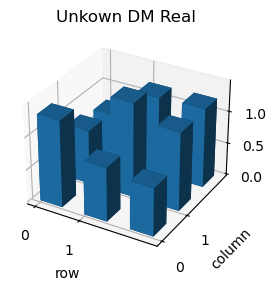

[[1.3314088  0.82819176 0.73772377]
 [0.82819176 1.44854809 1.20294386]
 [0.73772377 1.20294386 1.2200431 ]]


In [439]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

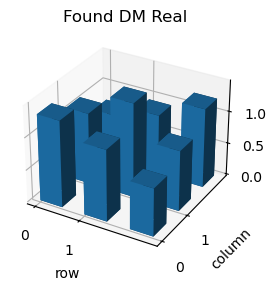

[[1.3315444  1.10086063 0.73780941]
 [1.10086063 1.44833524 0.93029801]
 [0.73780941 0.93029801 1.22012035]]


In [440]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

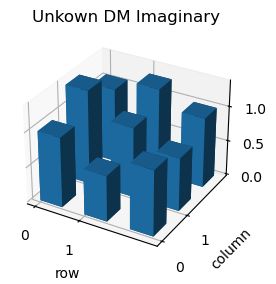

[[1.         0.65484103 0.93569293]
 [1.34515897 1.         0.76017985]
 [1.06430707 1.23982015 1.        ]]


In [441]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

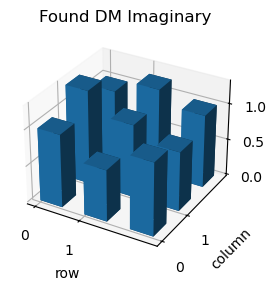

[[1.         0.70770746 1.00164886]
 [1.29229254 1.         0.81305327]
 [0.99835114 1.18694673 1.        ]]


In [442]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [443]:
# TEST: reconstruct statevector from psi
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    print(eigenvalues)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [444]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[-0.17870391-0.54724192j]
 [ 0.66259031+0.09758164j]
 [ 0.24761356+0.39841013j]]
prob_0 [0.3314088]
prob_1 [0.44854809]


#### original psi from density matrix, testing that it matches psi

In [445]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

[-1.23600308e-16 -1.05545699e-17  1.00000000e+00]
original_psi_from_dm [ 0.57568116+0.j         -0.2984434 +0.5995662j  -0.45559287+0.11170605j]
prob_0 0.33140880227576314
prob_1 0.4485480929459223


#### statevector from reconstructed dm

In [446]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

[5.93352493e-15 1.34142860e-01 8.65857140e-01]
found_psi_from_dm [-0.60225834+0.j         -0.21777674-0.62341546j  0.44852862+0.00578206j]
prob_0 0.3627151103227999
prob_1 0.4360735379573046


### State vector fidelity

In [447]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [448]:
statevector_fidelity(psi, found_psi_from_dm)

0.8078515380520013